In [124]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import pingouin as pg

## Generate Simulated Correlation Matrices

We decided to first test the GNN on simulated data. To do this, we need to generate data with simple relations between variables that would clearly show on a correlation matrix.

We start off by generating a n x m dataframe, where n is the number of of time points and m is the number of regions in our simplified model of the brain. Each cell in this dataframe is filled with random noise. The greater the number of time points n, the less noise will appear in the correlation matrix.

Then, each row of the dataframe has a low chance of being multiplied by a 1 x m vector, which is preset beforehand. This vector contains weights for each of the m regions and can be set to force regions to correlate with each other. For example, if regions  A and B have weights of 2 while the other regions have a weight of 1, then regions A and B will be positively correlated.

The chance for this multiplication to occur should not be too high or too low. If it is too low, then it will not occur if n is also low. If the chance is too high, then most of the rows will be multiplied and the increase/decrease instead becomes an inherent feature of the brain region.

In [279]:
def mult_chance(row,mult_lst,chance):
    if np.random.random() < chance:
        return row * mult_lst
    return row

def gen_data(mult_lst,num_rows,num_features = 10):
    # gen dataframe of random values from 0.1 to 0.2
    df = pd.DataFrame(np.random.uniform(0.1,0.2,size=(num_rows, num_features)))

    # multiply some rows by a specific list at a certain chance
    df = df.apply(lambda x: mult_chance(x,mult_lst,0.2), axis=1)
    return df

def plot_corr_pcorr(data):
    kwarg_dict = {'vmin':-1, 'vmax':1,'center':0}
    fig, ax = plt.subplots(1,2,figsize=(11,4))
    sns.heatmap(data.corr(), ax=ax[0],**kwarg_dict)
    ax[0].set_title("Pearson Correlation")
    sns.heatmap(data.pcorr(), ax=ax[1],**kwarg_dict)
    ax[1].set_title("Partial Correlation")
    plt.show()
    print("Pearson Positive Definite: ", np.all(np.linalg.eigvals(df.corr()) > 0))
    print("Partial Positive Definite: ", np.all(np.linalg.eigvals(df.pcorr()) > 0))
    
def only_heatmap(data):
    kwarg_dict = {'vmin':-1, 'vmax':1,'center':0}
    sns.heatmap(data,**kwarg_dict)

Here we have a simulated brain with 10 regions. Let us assume that in the male brain, regions 0 to 4 are correlated with each other. We can force this correlation by increasing the weights of the male_lst in regions 0 to 4 while leaving the other weights as 1.

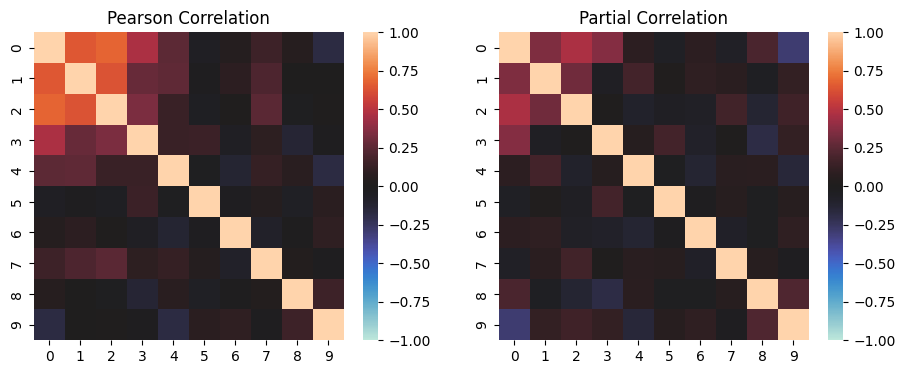

Pearson Positive Definite:  True
Partial Positive Definite:  True


In [277]:
male_lst = [
        2,
        1.8,
        1.6,
        1.4,
        1.2,
        1,
        1,
        1,
        1,
        1
    ]

df = gen_data(male_lst,100)
plot_corr_pcorr(df)

Let's also assume that in the female brain, regions 5 to 9 are correlated with each other.

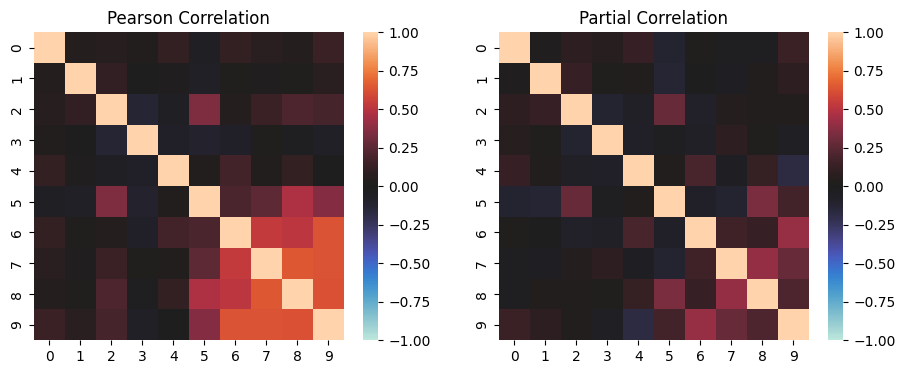

Pearson Positive Definite:  True
Partial Positive Definite:  True


In [256]:
female_lst = [
        1,
        1,
        1,
        1,
        1,
        1.2,
        1.4,
        1.6,
        1.8,
        2
    ]

df = gen_data(female_lst,100)
plot_corr_pcorr(df)

From the heatmaps above, we can see that the regions of the simulated brains that are correlated with each other are lit up, while the regions that are not correlated stay dark. The small amount of noise in the matrices can be removed by using a larger number of time points when generating the dataframe.

However, there is an issue with the partial correlation matrix. While the pearson correlation shows the correlation between multiple regions, the partial correlation excludes other regions when considering the relationship between two regions.

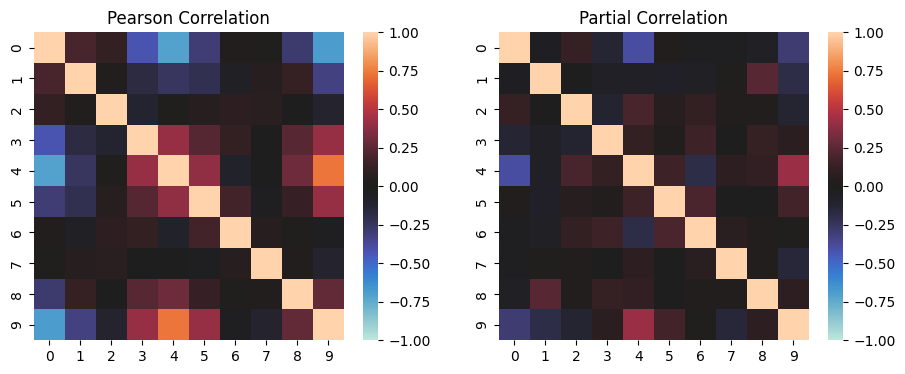

Pearson Positive Definite:  True
Partial Positive Definite:  True


In [270]:
some_lst = [0.4,0.8,1,1.2,2,1.2,1,1,1.2,2] # arbitrary

df = gen_data(some_lst,100)
plot_corr_pcorr(df)

In the heatmap above, the correlations are clearly shown on the pearson correlation but are very mute on the partial correlation. This means that the current method of multiplying the rows by only one vector will not work well in generating partial correlations.

In [271]:
def gen_data2(lst1,num_rows):
    df = pd.DataFrame(np.random.uniform(0.1,0.2,size=(num_rows, 10)))
    
    for lst2 in lst1:
        df = df.apply(lambda x: mult_chance(x,lst2,0.2), axis=1)    
    return df

This is an updated version of the data generation function. Instead of multiplying by one vector, each row of the data has a chance to be multiplied by multiple different vectors. This way, we can model more complex relationships in the correlation matrix.

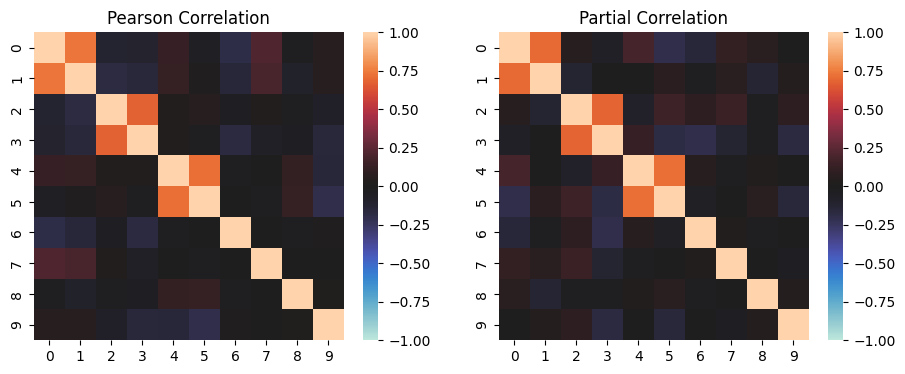

Pearson Positive Definite:  True
Partial Positive Definite:  False


In [260]:
tuple_lst = [
    [2,2,1,1,1,1,1,1,1,1], # region 0 with region 1
    [1,1,2,2,1,1,1,1,1,1], # region 2 with region 3
    [1,1,1,1,2,2,1,1,1,1] # region 3 with region 4
]

df = gen_data2(tuple_lst,100)
plot_corr_pcorr(df)

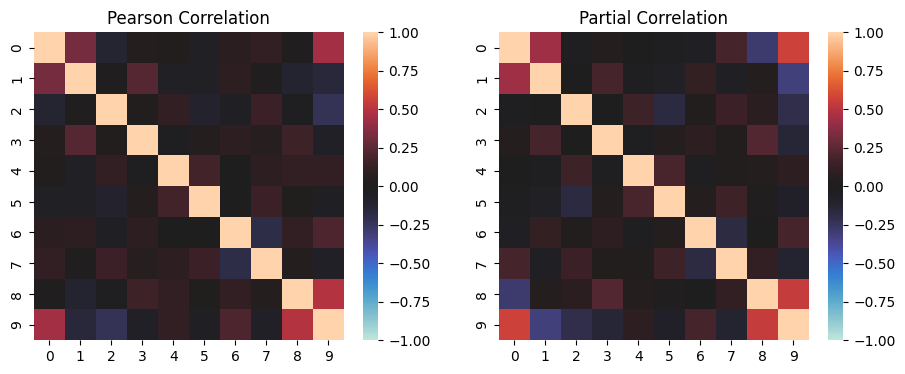

Pearson Positive Definite:  True
Partial Positive Definite:  False


In [276]:
tuple_lst = [
    [2,1.6,1,1.1,1,1,1,1,1,1], # regions 0 and 1
    [1,1,1,1,1,1,1.1,1,1.6,2], # regions 8 and 9
    [2,1,1,1,1,1,1,1,1,2], # region 0 with region 9
]

df = gen_data2(tuple_lst,100)
plot_corr_pcorr(df)

## What we will be using

The list below contains generated correlation matrices for 100 subjects. Index 0 has 'M' for male and 'F' for female. Index 1 and 2 are the pearson and partial correlation matrices.

In [289]:
simulated_subjects = []

for i in np.arange(50):
    df = gen_data(male_lst,100)
    simulated_subjects += [('M',df.corr(),df.pcorr())]
for i in np.arange(50):
    df = gen_data(female_lst,100)
    simulated_subjects += [('F',df.corr(),df.pcorr())]
random.shuffle(lst)

Gender: M


Text(0.5, 1.0, 'Partial Correlation')

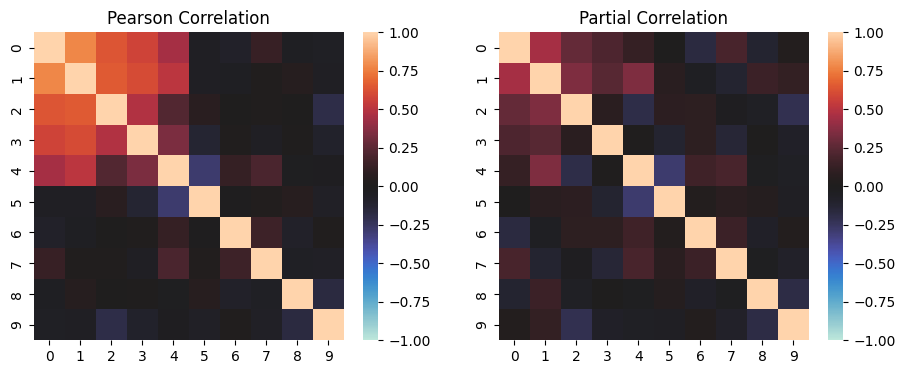

In [290]:
subject0 = simulated_subjects[0]
gender0 = subject0[0]
corr0 = subject0[1]
pcorr0 = subject0[2]

print("Gender:",gender0)
fig, ax = plt.subplots(1,2,figsize=(11,4))
sns.heatmap(corr0, ax=ax[0],**kwarg_dict)
ax[0].set_title("Pearson Correlation")
sns.heatmap(pcorr0, ax=ax[1],**kwarg_dict)
ax[1].set_title("Partial Correlation")

We also need an ideal brain for both male and female, where there is little to no noise in the correlation matrices. We can generate this by using a long time series to approximate the ideal.

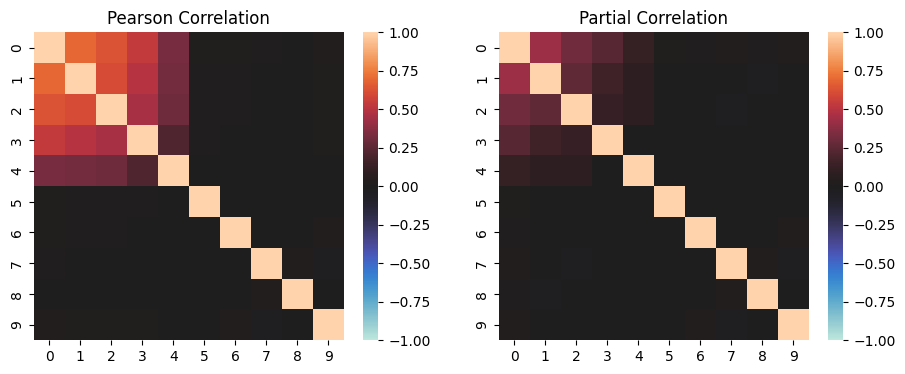

Pearson Positive Definite:  True
Partial Positive Definite:  True


In [291]:
male_ideal = gen_data(male_lst,5000)
plot_corr_pcorr(male_ideal)

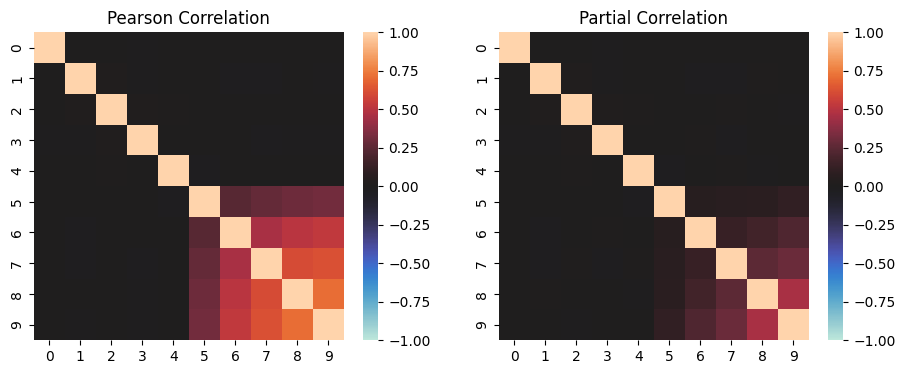

Pearson Positive Definite:  True
Partial Positive Definite:  True


In [292]:
female_ideal = gen_data(female_lst,5000)
plot_corr_pcorr(female_ideal)

## TODO list

- don't use 50 for two variables DONE
- account for pairwise correlation when generating sim data DONE
- generate list with df or just corr and pcorr DONE
- write description of how this data is generated DONE
- show positive definite mathematically DONE
    - only for pearson or also for partial?
- show fisher transform
- research how to create partial correlation from pairwise correlation DONE
- need one sim with long time series, approximate ideal DONE